In [1]:
# Add this cell and restart kernel
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

# Then restart and re-run everything

In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

class GDELTDataLoader:
    """Optimized GDELT news topic data loader"""
    
    def __init__(self):
        self.kaggle_paths = [
            Path("/kaggle/input/news-topic-update"),
            Path("/kaggle/input/news-topic-update/archive"),
            Path("../input/news-topic-update"),
            Path("../input/news-topic-update/archive"),
            Path("./data"),
            Path(".")
        ]
    
    def find_data_path(self):
        """Find Kaggle data path"""
        for path in self.kaggle_paths:
            if path.exists():
                print(f"✅ Found: {path}")
                return path
        return None
    
    def explore_files(self, base_path):
        """Explore directory structure"""
        try:
            csv_files = list(base_path.rglob("*.csv"))
            print(f"📁 Found {len(csv_files)} CSV files")
            
            files_info = {}
            for csv_file in csv_files:
                filename = csv_file.name.lower()
                parent = csv_file.parent.name.lower()
                
                # Identify file type
                if 'merged' in filename:
                    file_type = 'merged_train' if any(m in filename for m in ['april', 'may']) else 'merged_test'
                elif 'april' in parent:
                    file_type = 'daily_april'
                elif 'may' in parent:
                    file_type = 'daily_may'
                elif 'june' in parent:
                    file_type = 'daily_june'
                else:
                    file_type = 'unknown'
                
                files_info[csv_file.name] = {
                    'path': csv_file,
                    'size_mb': csv_file.stat().st_size / (1024 * 1024),
                    'type': file_type
                }
                
            return files_info
        except Exception as e:
            print(f"❌ Error exploring: {e}")
            return {}
    
    def read_csv(self, csv_file):
        """Read GDELT CSV file"""
        for sep in ['\t', ',']:
            try:
                df = pd.read_csv(csv_file, sep=sep, dtype=str, low_memory=False, 
                               on_bad_lines='skip', encoding='utf-8')
                if len(df.columns) > 1:
                    print(f"✅ Read {csv_file.name}: {df.shape}")
                    return df
            except:
                continue
        return None
    
    def process_gdelt_data(self, df):
        """Process GDELT data to extract themes as text"""
        try:
            if 'DATE' not in df.columns or 'THEMES' not in df.columns:
                return None
            
            # Convert date
            df['date'] = pd.to_datetime(df['DATE'], format='%Y%m%d', errors='coerce')
            
            # Process themes to text
            df['text'] = df['THEMES'].fillna('').apply(
                lambda x: ' '.join([theme.replace('_', ' ').lower() 
                                  for theme in x.split(';') if theme.strip()])
            )
            
            # Clean and filter
            result = df[['date', 'text']].dropna()
            result = result[result['text'].str.strip() != '']
            result = result.sort_values('date').reset_index(drop=True)
            
            print(f"✅ Processed: {len(result)} records ({result['date'].min()} to {result['date'].max()})")
            return result
            
        except Exception as e:
            print(f"❌ Processing error: {e}")
            return None
    
    def load_files_by_type(self, files_info, file_type):
        """Load and merge files by type"""
        target_files = [info for info in files_info.values() if info['type'] == file_type]
        
        if not target_files:
            return None
        
        all_data = []
        for file_info in target_files:
            df = self.read_csv(file_info['path'])
            if df is not None:
                processed = self.process_gdelt_data(df)
                if processed is not None:
                    all_data.append(processed)
        
        if all_data:
            combined = pd.concat(all_data, ignore_index=True)
            return combined.sort_values('date').reset_index(drop=True)
        
        return None
    
    def load_data(self):
        """Main data loading function"""
        print("🚀 GDELT DATA LOADER")
        print("=" * 50)
        
        # Find path
        base_path = self.find_data_path()
        if not base_path:
            return self.create_demo_data()
        
        # Explore files
        files_info = self.explore_files(base_path)
        if not files_info:
            return self.create_demo_data()
        
        # Load train data (April-May)
        train_data = None
        
        # Try merged file first
        merged_train = [f for f in files_info.values() if f['type'] == 'merged_train']
        if merged_train:
            df = self.read_csv(merged_train[0]['path'])
            if df is not None:
                train_data = self.process_gdelt_data(df)
        
        # Fallback to daily files
        if train_data is None:
            april = self.load_files_by_type(files_info, 'daily_april')
            may = self.load_files_by_type(files_info, 'daily_may')
            
            if april is not None and may is not None:
                train_data = pd.concat([april, may], ignore_index=True)
            else:
                train_data = april or may
        
        # Load test data (June - first 10 days)
        test_data = None
        
        # Try merged file first
        merged_test = [f for f in files_info.values() if f['type'] == 'merged_test']
        if merged_test:
            df = self.read_csv(merged_test[0]['path'])
            if df is not None:
                test_data = self.process_gdelt_data(df)
        
        # Fallback to daily files
        if test_data is None:
            test_data = self.load_files_by_type(files_info, 'daily_june')
        
        # Get first 10 days of test data
        if test_data is not None:
            unique_dates = sorted(test_data['date'].dt.date.unique())[:10]
            test_data = test_data[test_data['date'].dt.date.isin(unique_dates)]
        
        # Return results or demo data
        if train_data is not None and test_data is not None:
            print(f"\n✅ DATA LOADED SUCCESSFULLY!")
            print(f"🏋️ Train: {len(train_data)} records")
            print(f"🧪 Test: {len(test_data)} records")
            return train_data, test_data
        
        return self.create_demo_data()
    
    def create_demo_data(self):
        """Create demo data in GDELT format"""
        print("\n🎭 CREATING DEMO DATA")
        
        np.random.seed(42)
        
        # Sample GDELT themes
        themes = [
            'TRIAL;TAX_FNCACT;TAX_FNCACT_LAWYER',
            'WB_1979_NATURAL_RESOURCE_MANAGEMENT;WB_435_AGRICULTURE',
            'PORTSMEN_HOLIDAY;CRISISLEX_CRISISLEXREC',
            'TAX_FNCACT_POLICE;SOC_POINTSOFINTEREST_PRISON',
            'ARREST;TAX_FNCACT;TRIAL',
            'TERROR;ARMEDCONFLICT;TAX_ETHNICITY',
            'WB_826_TOURISM;WB_1921_COMPETITIVE_SECTORS',
            'EPU_ECONOMY;EPU_ECONOMY_HISTORIC',
            'MEDIA_MSM;AFFECT;BAN',
            'SECURITY_SERVICES;CRIME;WB_ILLEGAL_DRUGS'
        ]
        
        # Generate data
        def generate_data(start_date, end_date, articles_per_day=(20, 50)):
            data = []
            dates = pd.date_range(start_date, end_date, freq='D')
            
            for date in dates:
                n_articles = np.random.randint(*articles_per_day)
                for _ in range(n_articles):
                    theme = np.random.choice(themes)
                    text = theme.replace(';', ' ').replace('_', ' ').lower()
                    data.append({'date': date, 'text': text})
            
            return pd.DataFrame(data)
        
        train_data = generate_data('2024-04-01', '2024-05-31')
        test_data = generate_data('2024-06-01', '2024-06-10', (15, 40))
        
        print(f"📊 Demo train: {len(train_data)} records")
        print(f"📊 Demo test: {len(test_data)} records")
        
        return train_data, test_data

def main():
    """Main function"""
    loader = GDELTDataLoader()
    
    try:
        train_data, test_data = loader.load_data()
        
        # Save data
        try:
            train_data.to_csv('/kaggle/working/gdelt_train_data.csv', index=False)
            test_data.to_csv('/kaggle/working/gdelt_test_data.csv', index=False)
            print(f"\n💾 Data saved to /kaggle/working/")
        except:
            pass
        
        return train_data, test_data
        
    except Exception as e:
        print(f"❌ Error: {e}")
        return None, None

if __name__ == "__main__":
    train_data, test_data = main()

🚀 GDELT DATA LOADER
✅ Found: /kaggle/input/news-topic-update
📁 Found 74 CSV files
✅ Read merged_April_May_DATE_THEMES_URL.csv: (8650373, 3)
✅ Processed: 8158281 records (2025-04-01 00:00:00 to 2025-05-31 00:00:00)
✅ Read merged_gkg_june_data.csv: (1322408, 3)
✅ Processed: 1242757 records (2025-06-01 00:00:00 to 2025-06-10 00:00:00)

✅ DATA LOADED SUCCESSFULLY!
🏋️ Train: 8158281 records
🧪 Test: 1242757 records

💾 Data saved to /kaggle/working/


System: 4 CPUs, 31.4GB RAM
GDELT HOT TOPICS PROPHET + XGBOOST PIPELINE
Prophet + XGBoost Forecaster
Topics: 10 | Focus on top 3 | Forecast: 7 days

STEP 1: LOADING DATA

LOADING DATASETS...
Training: /kaggle/working/gdelt_train_data.csv
Testing: /kaggle/working/gdelt_test_data.csv
Loaded - Train: 8,158,281 | Test: 1,242,757

STEP 2: TOPIC EXTRACTION

EXTRACTING TOPICS...
Processing batch 1: 50,000 texts...
Valid texts: 49,992/50,000
Vectorizing 49,992 texts...
Training LDA model...

Discovered Topics:
Topic 0: public, econ, public sector, sector, debt
Topic 1: military, military title, title, officer, chief
Topic 2: transport, worldmammals, education, forests, oceans
Topic 3: natural disaster, natural, disaster, disaster natural, agriculture
Topic 4: media, applications, technologies, government broadcast, broadcast
Topic 5: corruption, police, anti, anti corruption, justice
Topic 6: education, jobs, labor, skills, jobs education
Topic 7: health, disease, nutrition, health nutrition, p

10:16:00 - cmdstanpy - INFO - Chain [1] start processing
10:16:01 - cmdstanpy - INFO - Chain [1] done processing
10:16:01 - cmdstanpy - INFO - Chain [1] start processing


Training Prophet for Topic 8...


10:16:01 - cmdstanpy - INFO - Chain [1] done processing
10:16:01 - cmdstanpy - INFO - Chain [1] start processing


Training Prophet for Topic 2...


10:16:01 - cmdstanpy - INFO - Chain [1] done processing


Trained 3 Prophet models

TRAINING XGBOOST MODELS...
Training XGBoost for Topic 5...
Training XGBoost for Topic 8...
Training XGBoost for Topic 2...
Trained 3 XGBoost models

STEP 5: ENSEMBLE FORECASTING

GENERATING ENSEMBLE FORECASTS...
Processing test data...
Processing batch 1: 50,000 texts...
Valid texts: 49,997/50,000
Processing batch 2: 50,000 texts...
Valid texts: 49,998/50,000
Processing batch 3: 50,000 texts...
Valid texts: 49,989/50,000
Processing batch 4: 50,000 texts...
Valid texts: 49,997/50,000
Processing batch 5: 50,000 texts...
Valid texts: 49,998/50,000
Processing batch 6: 50,000 texts...
Valid texts: 49,990/50,000
Processing batch 7: 50,000 texts...
Valid texts: 49,994/50,000
Processing batch 8: 50,000 texts...
Valid texts: 49,992/50,000
Processing batch 9: 50,000 texts...
Valid texts: 49,983/50,000
Processing batch 10: 50,000 texts...
Valid texts: 49,997/50,000
Processing batch 11: 50,000 texts...
Valid texts: 49,982/50,000
Processing batch 12: 50,000 texts...
Valid 

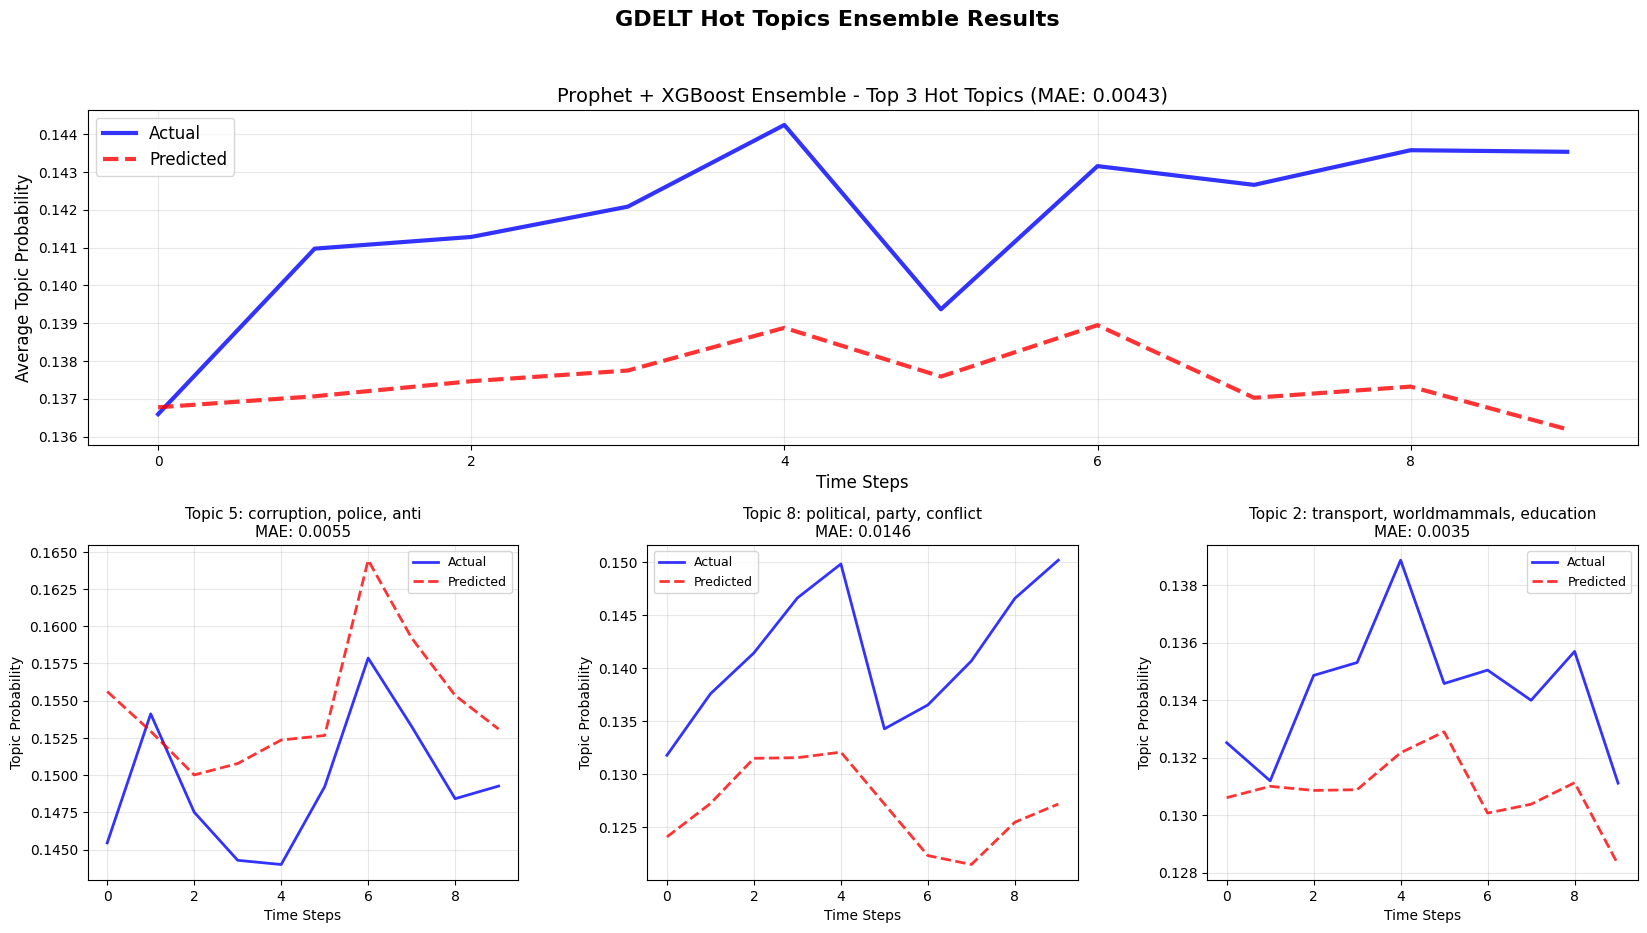


PIPELINE COMPLETED in 30.3 minutes
Hot topics: [5, 8, 2]
Overall MAE: 0.007861


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import xgboost as xgb
from prophet import Prophet
import re
import warnings
import os
import gc
import time
from datetime import datetime
import psutil

warnings.filterwarnings('ignore')
import logging
logging.getLogger('prophet').setLevel(logging.WARNING)
logging.getLogger('cmdstanpy').setLevel(logging.WARNING)

class ProphetXGBoostForecaster:
    def __init__(self, n_topics=10, top_k=3, forecast_horizon=7, batch_size=50000):
        self.n_topics = n_topics
        self.top_k = top_k
        self.forecast_horizon = forecast_horizon
        self.batch_size = batch_size
        
        self.vectorizer = None
        self.lda_model = None
        self.hot_topics = []
        self.topic_popularity = {}
        self.prophet_models = {}
        self.xgboost_models = {}
        self.feature_importance = {}
        
        self.gdelt_stopwords = {
            'wb', 'tax', 'fncact', 'soc', 'policy', 'pointsofinterest', 'crisislex', 
            'epu', 'uspec', 'ethnicity', 'worldlanguages', 'the', 'and', 'or', 
            'but', 'in', 'on', 'at', 'to', 'for', 'of', 'with', 'by', 'a', 'an'
        }
        
        print(f"Prophet + XGBoost Forecaster")
        print(f"Topics: {n_topics} | Focus on top {top_k} | Forecast: {forecast_horizon} days")
    
    def preprocess_text(self, text):
        if pd.isna(text) or text is None:
            return ""
        text = re.sub(r'[^a-zA-Z\s]', ' ', str(text).lower())
        text = re.sub(r'\s+', ' ', text).strip()
        words = [w for w in text.split() if len(w) > 2 and w not in self.gdelt_stopwords]
        return ' '.join(words[:40])
    
    def batch_preprocess(self, texts, batch_id=0):
        print(f"Processing batch {batch_id+1}: {len(texts):,} texts...")
        processed = [self.preprocess_text(text) for text in texts]
        valid_texts = [text for text in processed if text.strip()]
        print(f"Valid texts: {len(valid_texts):,}/{len(texts):,}")
        return valid_texts
    
    def load_datasets(self):
        print("\nLOADING DATASETS...")
        
        train_paths = ["/kaggle/working/gdelt_train_data.csv", "./gdelt_train_data.csv", "gdelt_train_data.csv"]
        test_paths = ["/kaggle/working/gdelt_test_data.csv", "./gdelt_test_data.csv", "gdelt_test_data.csv"]
        
        train_file = next((p for p in train_paths if os.path.exists(p)), None)
        test_file = next((p for p in test_paths if os.path.exists(p)), None)
        
        if not train_file or not test_file:
            raise FileNotFoundError("GDELT data files not found")
        
        print(f"Training: {train_file}")
        print(f"Testing: {test_file}")
        
        # Load training data
        train_chunks = []
        for chunk in pd.read_csv(train_file, usecols=['date', 'text'], 
                               parse_dates=['date'], chunksize=25000):
            chunk = chunk.dropna()
            chunk = chunk[chunk['text'].astype(str).str.strip() != '']
            if len(chunk) > 0:
                train_chunks.append(chunk)
        
        train_data = pd.concat(train_chunks, ignore_index=True).sort_values('date')
        
        # Load test data
        test_chunks = []
        for chunk in pd.read_csv(test_file, usecols=['date', 'text'], 
                               parse_dates=['date'], chunksize=25000):
            chunk = chunk.dropna()
            chunk = chunk[chunk['text'].astype(str).str.strip() != '']
            if len(chunk) > 0:
                test_chunks.append(chunk)
        
        test_data = pd.concat(test_chunks, ignore_index=True).sort_values('date')
        
        print(f"Loaded - Train: {len(train_data):,} | Test: {len(test_data):,}")
        gc.collect()
        
        return train_data, test_data
    
    def extract_topics(self, texts, dates):
        print("\nEXTRACTING TOPICS...")
        
        # Process first batch for vectorizer
        first_batch = self.batch_preprocess(texts[:self.batch_size], 0)
        
        self.vectorizer = TfidfVectorizer(
            max_features=1500, ngram_range=(1, 2), min_df=3,
            max_df=0.95, stop_words='english'
        )
        
        print(f"Vectorizing {len(first_batch):,} texts...")
        first_tfidf = self.vectorizer.fit_transform(first_batch)
        
        # Train LDA
        print("Training LDA model...")
        self.lda_model = LatentDirichletAllocation(
            n_components=self.n_topics, random_state=42,
            max_iter=15, learning_method='batch'
        )
        
        first_topic_dist = self.lda_model.fit_transform(first_tfidf)
        
        # Display topics
        feature_names = self.vectorizer.get_feature_names_out()
        print("\nDiscovered Topics:")
        for i, topic in enumerate(self.lda_model.components_):
            top_words = [feature_names[j] for j in topic.argsort()[-5:][::-1]]
            print(f"Topic {i}: {', '.join(top_words)}")
        
        all_topic_distributions = [first_topic_dist]
        
        # Process remaining batches
        total_batches = (len(texts) + self.batch_size - 1) // self.batch_size
        if total_batches > 1:
            print(f"\nProcessing {total_batches-1} remaining batches...")
            
            for batch_idx in range(1, total_batches):
                start_idx = batch_idx * self.batch_size
                end_idx = min(start_idx + self.batch_size, len(texts))
                batch_texts = texts[start_idx:end_idx]
                
                try:
                    batch_processed = self.batch_preprocess(batch_texts, batch_idx)
                    if batch_processed:
                        batch_tfidf = self.vectorizer.transform(batch_processed)
                        batch_topics = self.lda_model.transform(batch_tfidf)
                        all_topic_distributions.append(batch_topics)
                except:
                    fallback = np.full((len(batch_texts), self.n_topics), 1.0/self.n_topics)
                    all_topic_distributions.append(fallback)
        
        combined_topic_dist = np.vstack(all_topic_distributions)
        
        # Identify hot topics
        self.identify_hot_topics(combined_topic_dist, dates)
        
        return combined_topic_dist
    
    def identify_hot_topics(self, topic_dist, dates):
        print("\nIDENTIFYING HOT TOPICS...")
        
        df = pd.DataFrame(topic_dist, columns=[f'topic_{i}' for i in range(self.n_topics)])
        df['date'] = pd.to_datetime(dates)
        
        topic_scores = {}
        
        for topic_idx in range(self.n_topics):
            topic_col = f'topic_{topic_idx}'
            
            avg_prob = df[topic_col].mean()
            recent_avg = df[topic_col].iloc[int(0.7 * len(df)):].mean()
            variance = df[topic_col].var()
            
            daily_avg = df.groupby('date')[topic_col].mean()
            peak_intensity = daily_avg.max()
            
            hotness_score = 0.3 * avg_prob + 0.3 * recent_avg + 0.2 * variance + 0.2 * peak_intensity
            
            topic_scores[topic_idx] = {
                'hotness_score': hotness_score,
                'avg_prob': avg_prob,
                'recent_avg': recent_avg,
                'variance': variance
            }
        
        sorted_topics = sorted(topic_scores.items(), key=lambda x: x[1]['hotness_score'], reverse=True)
        self.hot_topics = [topic_idx for topic_idx, _ in sorted_topics[:self.top_k]]
        self.topic_popularity = topic_scores
        
        print(f"\nTop {self.top_k} Hot Topics:")
        feature_names = self.vectorizer.get_feature_names_out()
        for rank, topic_idx in enumerate(self.hot_topics, 1):
            topic_words = [feature_names[j] for j in self.lda_model.components_[topic_idx].argsort()[-5:][::-1]]
            scores = topic_scores[topic_idx]
            print(f"#{rank}. Topic {topic_idx}: {', '.join(topic_words)}")
            print(f"    Hotness: {scores['hotness_score']:.4f} | Avg: {scores['avg_prob']:.4f}")
    
    def prepare_time_series(self, topic_dist, dates):
        print("\nPREPARING TIME SERIES DATA...")
        
        df = pd.DataFrame(topic_dist, columns=[f'topic_{i}' for i in range(self.n_topics)])
        df['date'] = pd.to_datetime(dates)
        
        daily_data = df.groupby('date').mean().reset_index()
        
        # Add time features
        daily_data['day_of_week'] = daily_data['date'].dt.dayofweek
        daily_data['day_of_month'] = daily_data['date'].dt.day
        daily_data['month'] = daily_data['date'].dt.month
        daily_data['is_weekend'] = daily_data['day_of_week'].isin([5, 6]).astype(int)
        
        # Lagged features for hot topics
        for lag in [1, 2, 3, 7]:
            for topic_idx in self.hot_topics:
                daily_data[f'topic_{topic_idx}_lag_{lag}'] = daily_data[f'topic_{topic_idx}'].shift(lag)
        
        # Rolling averages
        for window in [3, 7]:
            for topic_idx in self.hot_topics:
                daily_data[f'topic_{topic_idx}_ma_{window}'] = daily_data[f'topic_{topic_idx}'].rolling(window).mean()
        
        # Cross-topic interactions
        for i, topic_i in enumerate(self.hot_topics):
            for j, topic_j in enumerate(self.hot_topics):
                if i < j:
                    daily_data[f'topic_{topic_i}_x_{topic_j}'] = daily_data[f'topic_{topic_i}'] * daily_data[f'topic_{topic_j}']
        
        daily_data = daily_data.dropna()
        print(f"Prepared {len(daily_data)} days with {daily_data.shape[1]} features")
        
        return daily_data
    
    def train_prophet_models(self, daily_data):
        print("\nTRAINING PROPHET MODELS...")
        
        prophet_params = {
            'daily_seasonality': False,
            'weekly_seasonality': True,
            'yearly_seasonality': False,
            'changepoint_prior_scale': 0.1,
            'interval_width': 0.8
        }
        
        for topic_idx in self.hot_topics:
            print(f"Training Prophet for Topic {topic_idx}...")
            
            prophet_data = pd.DataFrame({
                'ds': daily_data['date'],
                'y': daily_data[f'topic_{topic_idx}']
            })
            
            model = Prophet(**prophet_params)
            model.fit(prophet_data)
            self.prophet_models[f'topic_{topic_idx}'] = model
        
        print(f"Trained {len(self.prophet_models)} Prophet models")
    
    def train_xgboost_models(self, daily_data):
        print("\nTRAINING XGBOOST MODELS...")
        
        feature_cols = ['day_of_week', 'day_of_month', 'month', 'is_weekend']
        feature_cols += [col for col in daily_data.columns if 'lag_' in col or 'ma_' in col or '_x_' in col]
        
        for topic_idx in self.hot_topics:
            print(f"Training XGBoost for Topic {topic_idx}...")
            
            other_topics = [f'topic_{i}' for i in self.hot_topics if i != topic_idx]
            X_features = feature_cols + other_topics
            
            X = daily_data[X_features].values
            y = daily_data[f'topic_{topic_idx}'].values
            
            split_idx = int(0.8 * len(X))
            X_train, X_val = X[:split_idx], X[split_idx:]
            y_train, y_val = y[:split_idx], y[split_idx:]
            
            model = xgb.XGBRegressor(
                n_estimators=100, max_depth=6, learning_rate=0.1,
                random_state=42, n_jobs=-1, verbosity=0
            )
            
            model.fit(X_train, y_train, eval_set=[(X_val, y_val)], 
                     early_stopping_rounds=10, verbose=False)
            
            self.xgboost_models[f'topic_{topic_idx}'] = model
            self.feature_importance[f'topic_{topic_idx}'] = dict(zip(X_features, model.feature_importances_))
        
        print(f"Trained {len(self.xgboost_models)} XGBoost models")
    
    def forecast_ensemble(self, test_texts, test_dates, daily_train_data):
        print("\nGENERATING ENSEMBLE FORECASTS...")
        
        # Process test data
        test_topic_dist = self.process_test_data(test_texts)
        test_daily_data = self.prepare_test_time_series(test_topic_dist, test_dates, daily_train_data)
        
        # Prophet forecasts
        prophet_preds = []
        for topic_idx in self.hot_topics:
            model = self.prophet_models[f'topic_{topic_idx}']
            future_df = pd.DataFrame({'ds': test_daily_data['date']})
            forecast = model.predict(future_df)
            prophet_preds.append(forecast['yhat'].values)
        prophet_preds = np.array(prophet_preds).T
        
        # XGBoost predictions
        xgb_preds = []
        feature_cols = ['day_of_week', 'day_of_month', 'month', 'is_weekend']
        feature_cols += [col for col in test_daily_data.columns if 'lag_' in col or 'ma_' in col or '_x_' in col]
        
        for topic_idx in self.hot_topics:
            model = self.xgboost_models[f'topic_{topic_idx}']
            other_topics = [f'topic_{i}' for i in self.hot_topics if i != topic_idx]
            X_features = feature_cols + other_topics
            X = test_daily_data[X_features].values
            predictions = model.predict(X)
            xgb_preds.append(predictions)
        xgb_preds = np.array(xgb_preds).T
        
        # Ensemble combination
        final_predictions = 0.5 * prophet_preds + 0.5 * xgb_preds
        
        hot_topic_cols = [f'topic_{i}' for i in self.hot_topics]
        actual_values = test_daily_data[hot_topic_cols].values
        
        print(f"Generated predictions for {len(final_predictions)} days")
        
        return final_predictions, actual_values, test_daily_data['date']
    
    def process_test_data(self, test_texts):
        print("Processing test data...")
        
        test_batches = (len(test_texts) + self.batch_size - 1) // self.batch_size
        test_topic_distributions = []
        
        for batch_idx in range(test_batches):
            start_idx = batch_idx * self.batch_size
            end_idx = min(start_idx + self.batch_size, len(test_texts))
            batch_texts = test_texts[start_idx:end_idx]
            
            try:
                batch_processed = self.batch_preprocess(batch_texts, batch_idx)
                if batch_processed:
                    batch_tfidf = self.vectorizer.transform(batch_processed)
                    batch_topics = self.lda_model.transform(batch_tfidf)
                    test_topic_distributions.append(batch_topics)
                else:
                    fallback = np.full((len(batch_texts), self.n_topics), 1.0/self.n_topics)
                    test_topic_distributions.append(fallback)
            except:
                fallback = np.full((len(batch_texts), self.n_topics), 1.0/self.n_topics)
                test_topic_distributions.append(fallback)
        
        return np.vstack(test_topic_distributions)
    
    def prepare_test_time_series(self, test_topic_dist, test_dates, train_data):
        df = pd.DataFrame(test_topic_dist, columns=[f'topic_{i}' for i in range(self.n_topics)])
        df['date'] = pd.to_datetime(test_dates)
        
        test_daily = df.groupby('date').mean().reset_index()
        
        # Add time features
        test_daily['day_of_week'] = test_daily['date'].dt.dayofweek
        test_daily['day_of_month'] = test_daily['date'].dt.day
        test_daily['month'] = test_daily['date'].dt.month
        test_daily['is_weekend'] = test_daily['day_of_week'].isin([5, 6]).astype(int)
        
        # Combine with training data for lags
        last_train_days = train_data.tail(10).copy()
        combined = pd.concat([last_train_days, test_daily], ignore_index=True)
        
        # Create features
        for lag in [1, 2, 3, 7]:
            for topic_idx in self.hot_topics:
                combined[f'topic_{topic_idx}_lag_{lag}'] = combined[f'topic_{topic_idx}'].shift(lag)
        
        for window in [3, 7]:
            for topic_idx in self.hot_topics:
                combined[f'topic_{topic_idx}_ma_{window}'] = combined[f'topic_{topic_idx}'].rolling(window).mean()
        
        for i, topic_i in enumerate(self.hot_topics):
            for j, topic_j in enumerate(self.hot_topics):
                if i < j:
                    combined[f'topic_{topic_i}_x_{topic_j}'] = combined[f'topic_{topic_i}'] * combined[f'topic_{topic_j}']
        
        test_with_features = combined.tail(len(test_daily)).dropna()
        return test_with_features
    
    def analyze_results(self, predictions, actuals, dates):
        print("\nANALYZING RESULTS...")
        
        mse = mean_squared_error(actuals, predictions)
        mae = mean_absolute_error(actuals, predictions)
        rmse = np.sqrt(mse)
        
        print(f"Overall Performance:")
        print(f"  MSE: {mse:.6f}")
        print(f"  MAE: {mae:.6f}")
        print(f"  RMSE: {rmse:.6f}")
        
        # Per-topic metrics
        topic_metrics = []
        for i, topic_idx in enumerate(self.hot_topics):
            topic_mae = mean_absolute_error(actuals[:, i], predictions[:, i])
            topic_metrics.append({'topic': topic_idx, 'mae': topic_mae})
        
        print(f"\nPer-Topic Performance:")
        for metric in topic_metrics:
            print(f"  Topic {metric['topic']}: MAE={metric['mae']:.4f}")
        
        # Visualization
        self.plot_results(predictions, actuals, dates, topic_metrics)
        
        return {'overall': {'mse': mse, 'mae': mae, 'rmse': rmse}, 'topics': topic_metrics}
    
    def plot_results(self, predictions, actuals, dates, topic_metrics):
        print("Creating visualizations...")
        
        fig = plt.figure(figsize=(20, 10))
        gs = fig.add_gridspec(2, 3, hspace=0.3, wspace=0.3)
        
        # Overall trend
        ax1 = fig.add_subplot(gs[0, :])
        pred_mean = predictions.mean(axis=1)
        actual_mean = actuals.mean(axis=1)
        time_steps = np.arange(len(pred_mean))
        
        ax1.plot(time_steps, actual_mean, 'b-', label='Actual', linewidth=3, alpha=0.8)
        ax1.plot(time_steps, pred_mean, 'r--', label='Predicted', linewidth=3, alpha=0.8)
        
        overall_mae = np.mean(np.abs(actual_mean - pred_mean))
        ax1.set_title(f'Prophet + XGBoost Ensemble - Top {self.top_k} Hot Topics (MAE: {overall_mae:.4f})', fontsize=14)
        ax1.set_xlabel('Time Steps', fontsize=12)
        ax1.set_ylabel('Average Topic Probability', fontsize=12)
        ax1.legend(fontsize=12)
        ax1.grid(True, alpha=0.3)
        
        # Individual topics
        feature_names = self.vectorizer.get_feature_names_out()
        for idx, (topic_idx, metric) in enumerate(zip(self.hot_topics[:3], topic_metrics[:3])):
            ax = fig.add_subplot(gs[1, idx])
            
            actual_data = actuals[:, idx]
            pred_data = predictions[:, idx]
            time_steps_topic = np.arange(len(actual_data))
            
            ax.plot(time_steps_topic, actual_data, 'b-', label='Actual', linewidth=2, alpha=0.8)
            ax.plot(time_steps_topic, pred_data, 'r--', label='Predicted', linewidth=2, alpha=0.8)
            
            topic_words = [feature_names[j] for j in self.lda_model.components_[topic_idx].argsort()[-3:][::-1]]
            ax.set_title(f'Topic {topic_idx}: {", ".join(topic_words)}\nMAE: {metric["mae"]:.4f}', fontsize=11)
            ax.set_xlabel('Time Steps', fontsize=10)
            ax.set_ylabel('Topic Probability', fontsize=10)
            ax.legend(fontsize=9)
            ax.grid(True, alpha=0.3)
        
        plt.suptitle('GDELT Hot Topics Ensemble Results', fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.show()


def run_pipeline():
    print("GDELT HOT TOPICS PROPHET + XGBOOST PIPELINE")
    print("=" * 60)
    
    total_start = time.time()
    
    # Initialize
    forecaster = ProphetXGBoostForecaster(n_topics=10, top_k=3, forecast_horizon=7)
    
    # Load data
    print("\nSTEP 1: LOADING DATA")
    train_data, test_data = forecaster.load_datasets()
    
    # Extract topics
    print("\nSTEP 2: TOPIC EXTRACTION")
    train_topics = forecaster.extract_topics(train_data['text'].tolist(), train_data['date'])
    
    # Prepare time series
    print("\nSTEP 3: TIME SERIES PREPARATION")
    daily_train_data = forecaster.prepare_time_series(train_topics, train_data['date'])
    
    # Train models
    print("\nSTEP 4: MODEL TRAINING")
    forecaster.train_prophet_models(daily_train_data)
    forecaster.train_xgboost_models(daily_train_data)
    
    # Forecast
    print("\nSTEP 5: ENSEMBLE FORECASTING")
    predictions, actuals, test_dates = forecaster.forecast_ensemble(
        test_data['text'].tolist(), test_data['date'], daily_train_data
    )
    
    # Analyze
    print("\nSTEP 6: RESULTS ANALYSIS")
    results = forecaster.analyze_results(predictions, actuals, test_dates)
    
    total_time = time.time() - total_start
    print(f"\nPIPELINE COMPLETED in {total_time/60:.1f} minutes")
    print(f"Hot topics: {forecaster.hot_topics}")
    print(f"Overall MAE: {results['overall']['mae']:.6f}")
    
    return forecaster, predictions, actuals, results


if __name__ == "__main__":
    print(f"System: {os.cpu_count()} CPUs, {psutil.virtual_memory().total/1024**3:.1f}GB RAM")
    forecaster, predictions, actuals, results = run_pipeline()